<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [ ]:
!pip install -U "transformers>=4.45.0" "accelerate>=0.33.0" "bitsandbytes==0.43.1"

In [ ]:
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers openpyxl datasets langchain-community ragatouille umap-learn

In [4]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from ragatouille import RAGPretrainedModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from ragatouille import RAGPretrainedModel
#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

/tmp/ipython-input-4262317610.py:17: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


In [ ]:
!pip install -q langchain-experimental

In [6]:
from langchain_experimental.text_splitter import SemanticChunker # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [ ]:
pd.set_option("display.max_colwidth", None)

In [7]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=a675bb7f-a5d1-4ba7-900a-344f0bd355f7
To: /content/file.csv
100%|██████████| 672M/672M [00:09<00:00, 67.4MB/s]


In [ ]:
data = pd.read_csv('file.csv')

In [ ]:
pd.set_option("display.max_colwidth", 50)

In [ ]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
data['en_txt'][:21]

,en_txt
0,there are two people that are standing on a track in a stadium
1,arafed building with a blue and white exterior and a blue fence
2,there is a blue and white building with a clock on top
3,there is a blue and white building with a clock on top
4,there is a boat that is in the water near a building
5,there is a building with a clock tower in the middle of a flower garden
6,aerial view of a city with a soccer field and a large orange dome
7,a view of a building with a clock tower on top of it
8,arafed building with a blue and white sign on it
9,arafed building with a blue and white sign on the side of it


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [8]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [ ]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

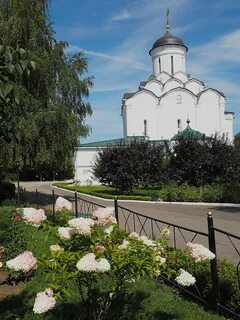

In [ ]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

### EDA

In [9]:
# Убедимся, что нет NaN
data['description'] = data['description'].fillna('')
data['en_txt'] = data['en_txt'].fillna('')

# Длина в символах
data['desc_len'] = data['description'].str.len()
data['blip_len'] = data['en_txt'].str.len()

# Длина в словах (для BLIP — на английском, split по пробелам корректен)
data['blip_words'] = data['en_txt'].str.split().str.len()

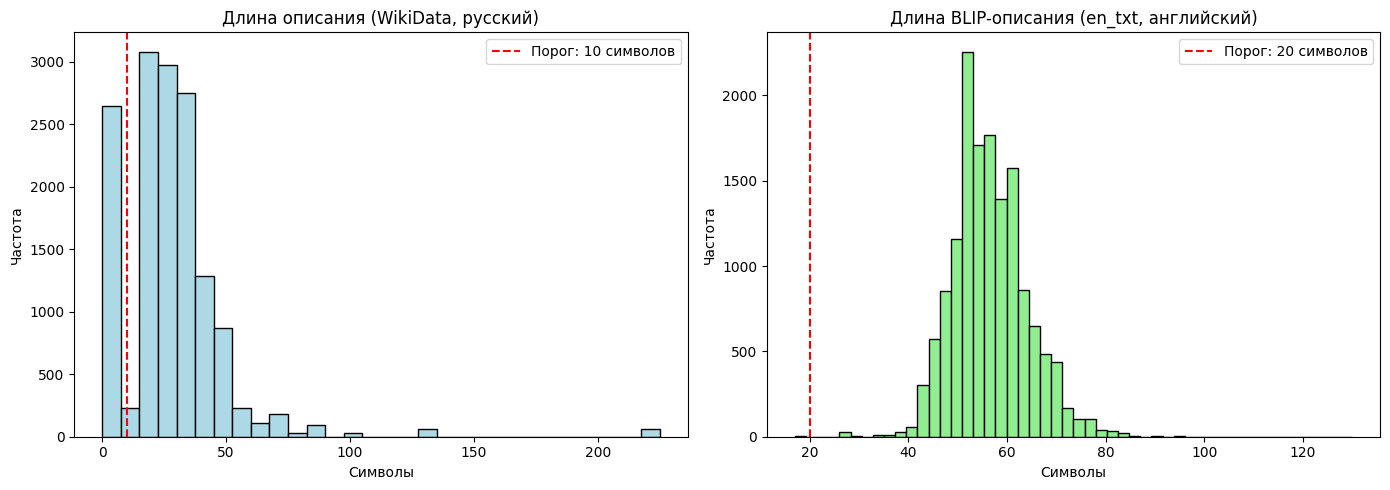

In [ ]:
plt.figure(figsize=(14, 5))

# WikiData description (обычно короткое)
plt.subplot(1, 2, 1)
plt.hist(data['desc_len'], bins=30, color='lightblue', edgecolor='black')
plt.title('Длина описания (WikiData, русский)')
plt.xlabel('Символы')
plt.ylabel('Частота')
plt.axvline(10, color='red', linestyle='--', label='Порог: 10 символов')
plt.legend()

# BLIP description (en_txt)
plt.subplot(1, 2, 2)
plt.hist(data['blip_len'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Длина BLIP-описания (en_txt, английский)')
plt.xlabel('Символы')
plt.ylabel('Частота')
plt.axvline(20, color='red', linestyle='--', label='Порог: 20 символов')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Найдём записи с очень коротким en_txt
short_blip = data[data['blip_len'] < 20]

print(f"Всего записей: {len(data)}")
print(f"Записей с en_txt короче 20 символов: {len(short_blip)}")

# Посмотрим примеры
print("\nПримеры подозрительных BLIP-описаний:")
for idx, row in short_blip.head(10).iterrows():
    print(f"- '{row['en_txt']}' → {row['Name']} ({row['City']})")

Всего записей: 14634
Записей с en_txt короче 20 символов: 2

Примеры подозрительных BLIP-описаний:
- 'the logo for nevm' → Музей непридуманных историй (Владимир)
- 'прррмомоннннннннннн' → Ярославский дворец молодёжи (Ярославль)


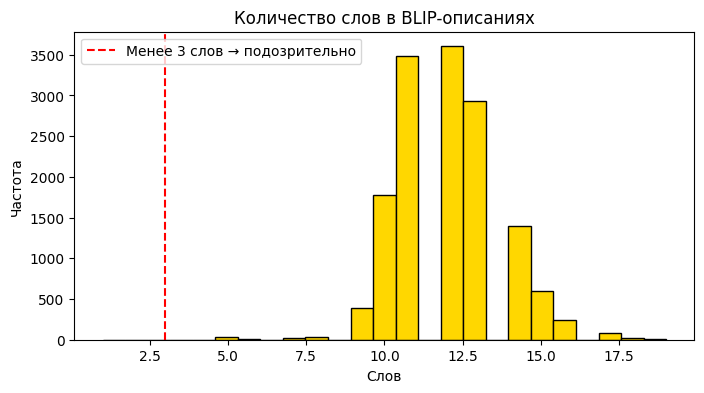

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(data['blip_words'], bins=25, color='gold', edgecolor='black')
plt.title('Количество слов в BLIP-описаниях')
plt.xlabel('Слов')
plt.ylabel('Частота')
plt.axvline(3, color='red', linestyle='--', label='Менее 3 слов → подозрительно')
plt.legend()
plt.show()

1. Очень короткие описания (<10 символов) — могут быть пустыми или мусорными → можно отфильтровать.
Но большинство описаний — достаточно информативны, даже если коротки.
Не стоит удалять все <10 — возможно, там есть "Дом", "Мост", "Памятник" — это тоже полезно.

2. BLIP-описания длиной <20 символов — почти всегда мусор: "a photo", "image", "building" и т.п.
Такие описания не добавляют ценности — их можно смело удалять.
Описания >20 символов — обычно содержательны: "there is a blue and white building...".

3. На графике видно, что есть небольшое количество записей с 1–2 словами.
Это почти всегда мусор.

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

### Очистка

In [11]:
# Длины для фильтрации
data['desc_len'] = data['description'].str.len()
data['blip_len'] = data['en_txt'].str.len()
data['blip_words'] = data['en_txt'].str.split().str.len()

# УМЕРЕННАЯ фильтрация (сохраняем объекты!)
data_clean = data[
    (data['desc_len'] > 0) |                     # Оставляем, если есть описание ИЛИ
    ((data['blip_len'] >= 10) & (data['blip_words'] >= 2))  # хороший BLIP
]

print(f"Осталось объектов: {len(data_clean)} из {len(data)}")

Осталось объектов: 14634 из 14634


### Чанки

In [12]:
# Группировка и создание чанков
chunks = data_clean.groupby('WikiData').apply(
    lambda g: f"""
{g['Name'].iloc[0]} — это {g['description'].iloc[0]} в городе {g['City'].iloc[0]}.
Также известен как: {g['Name'].iloc[0]}.
BLIP-описания: {' '.join(g['en_txt'].tolist())}
""".strip()
).reset_index(name='chunk')

/tmp/ipython-input-961189211.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chunks = data_clean.groupby('WikiData').apply(


In [ ]:
chunks

,WikiData,chunk
0,Q100270892,Нижегородский Кремль — это историческое здание...
1,Q100701435,Гарнизонная казарма — это здание в Нижегородск...
2,Q100882660,Губернаторский сад — это парк в Нижегородском ...
3,Q104554178,Церковь Николы в Меленках — это Православный х...
4,Q104776528,Церковь в честь Преображения Господня — это Сп...
...,...,...
291,Q97999957,Здание Удельной конторы — это Здание Удельной ...
292,Q98381215,Дом архитектора — это Жилой дом горьковского а...
293,Q99522676,Рекорд — это Общежитие института инженеров вод...
294,Q99622643,Дворец вице-губернатора — это административное...


In [ ]:
import langchain
import ragatouille
print("LangChain:", langchain.__version__)
print("RAGatouille:", ragatouille.__version__)

LangChain: 0.3.27
RAGatouille: 0.0.9post2


## Загрузки

In [13]:
!pip install -q faiss-cpu transformers torch

import torch
import torch.nn.functional as F
import faiss
from transformers import AutoTokenizer, AutoModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "bert-base-multilingual-cased"

print(f"Загружаем модель: {MODEL_NAME} на {DEVICE}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

Загружаем модель: bert-base-multilingual-cased на cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

## Индексация чанков при помощи ColBert

ColBERT:

* Преобразует запрос в токены и их векторы
* Сравнивает каждый токен запроса с каждым токеном в каждом чанке
* Вычисляет MaxSim (максимальное сходство) для каждой пары (запрос, чанк)
* Возвращает топ-k чанков по убыванию релевантности


In [14]:
# Кодирование на уровне токенов
def encode_colbert(texts, max_length=512):
    if isinstance(texts, str):
        texts = [texts]
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state
        mask = inputs['attention_mask'].unsqueeze(-1).expand(embeddings.size())
        embeddings = embeddings * mask
    return embeddings, inputs['attention_mask']

# MaxSim scoring
def maxsim_score(query_emb, doc_emb, query_mask):
    Q = F.normalize(query_emb.squeeze(0), dim=-1)
    D = F.normalize(doc_emb.squeeze(0), dim=-1)
    sims = torch.matmul(Q, D.T)
    max_sims = torch.max(sims, dim=1).values
    mask = query_mask.squeeze(0).float()
    return torch.sum(max_sims * mask).item()

# Создание FAISS-индекса ([CLS] токен)
def create_faiss_index(passages):
    cls_embeddings = []
    for p in passages:
        emb, _ = encode_colbert(p)
        cls_emb = emb[:, 0, :].cpu().numpy()
        cls_embeddings.append(cls_emb)
    cls_embeddings = np.vstack(cls_embeddings).astype('float32')
    faiss_index = faiss.IndexFlatIP(cls_embeddings.shape[1])
    faiss.normalize_L2(cls_embeddings)
    faiss_index.add(cls_embeddings)
    return faiss_index

# Класс RAG
class ColBERTRAG:
    def __init__(self, passages):
        self.passages = passages
        self.faiss_index = create_faiss_index(passages)

    def retrieve(self, query, k=3):
        # Этап 1: Быстрый поиск через FAISS
        query_emb, _ = encode_colbert(query)
        query_vec = query_emb[:, 0, :].cpu().numpy().astype('float32')
        faiss.normalize_L2(query_vec)
        _, indices = self.faiss_index.search(query_vec, k*5)
        candidates = [self.passages[i] for i in indices[0] if i != -1]
        cand_indices = [i for i in indices[0] if i != -1]

        if not candidates:
            return [], []

        # Этап 2: MaxSim реранкинг
        query_emb_full, query_mask = encode_colbert(query)
        scores = []
        for cand in candidates:
            doc_emb, _ = encode_colbert(cand)
            score = maxsim_score(query_emb_full, doc_emb, query_mask)
            scores.append(score)

        # Сортировка
        sorted_pairs = sorted(zip(scores, candidates, cand_indices), reverse=True)
        top_k = sorted_pairs[:k]
        return [c for _, c, _ in top_k], [i for _, _, i in top_k]

**FAISS - это один вектор на документ, ColBert - Много векторов (токенов) на документ. И здесь используем не косинусное расстояние, а контекстное сравнение "запрос ↔ каждый токен документа". В данном случае все происходит медленнее, но мы рассчитываем получить большую точность. Здесь мы не работаем напрямую с эмбеддингами, рни скрыты внутри индексов**

## Визуализация

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

**ColBERT (внутри ragatouille) не даёт одного вектора на документ — он хранит много векторов (токенов) и использует их для контекстного сравнения (ранжирования). Но PCA/UMAP не могут работать с таким форматом — им нужна единая числовая строка на объект.
Поэтому для цели визуализации мы используем классические dense-эмбеддинги от sentence-transformers.**

In [ ]:
# your code here

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Быстро получаем эмбеддинги для визуализации
print("Получаем эмбеддинги для PCA/UMAP...")
emb_model = SentenceTransformer('intfloat/multilingual-e5-large')
embeddings_for_viz = emb_model.encode(chunks['chunk'].tolist(), show_progress_bar=True)

# Теперь можно передавать `embeddings_for_viz` в PCA и UMAP (как в предыдущем ответе)

Получаем эмбеддинги для PCA/UMAP...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

### UMAP

In [ ]:
import umap
umap_reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
emb_umap = umap_reducer.fit_transform(embeddings_for_viz)

# 3. df_umap
import pandas as pd
df_umap = pd.DataFrame({
    'x': emb_umap[:, 0],
    'y': emb_umap[:, 1],
    'WikiData': chunks['WikiData']  # у вас эта колонка точно есть
})

# 4. Кластеризация
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
clusters = clusterer.fit_predict(emb_umap)

# 5. Добавьте кластеры в df_umap
df_umap['cluster'] = clusters

# 6. Визуализация
import plotly.express as px
fig = px.scatter(
    df_umap,
    x='x', y='y',
    color='cluster',
    hover_data=['WikiData'],
    title="UMAP + HDBSCAN: кластеризация чанков",
    width=900, height=600
)
fig.update_traces(marker=dict(size=9, opacity=0.8))
fig.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

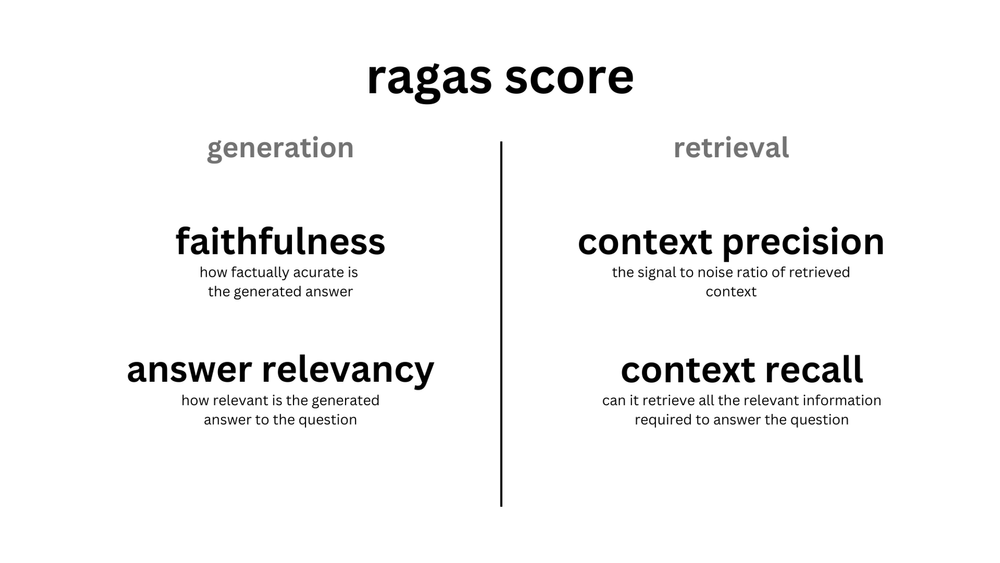

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.:

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

# Протестируйте ваш RAG (3 балла)

In [ ]:
# Создаём RAG-систему
passages = chunks['chunk'].tolist()
rag = ColBERTRAG(passages)

# Тестируем
query = "Расскажи про Нижегородский Кремль в Новгороде"
results, indices = rag.retrieve(query, k=7)

print("РЕЗУЛЬТАТЫ ПОИСКА:")
for i, res in enumerate(results, 1):
    status = "✅" if "Нижегородский Кремль" in res else "❌"
    print(f"\n--- {status} Результат {i} ---")
    print(res[:350])

РЕЗУЛЬТАТЫ ПОИСКА:

--- ✅ Результат 1 ---
Нижегородский Кремль — это историческое здание в Нижнем Новгороде, Россия в городе Нижний Новгород.
Также известен как: Нижегородский Кремль.
BLIP-описания: arafed view of a castle on a hill with a river in front there is a large grassy hill with a staircase going up it arafed view of a castle on a hill with a green hill in the background arafed br

--- ❌ Результат 2 ---
Нижегородский острог — это Нижегородский острог в городе Нижний Новгород.
Также известен как: Нижегородский острог.
BLIP-описания: there is a large white building with a tower on the top arafed white building with a tower and a clock on top aerial view of a large white building with a truck parked in front of it there is a large room with a balcony

--- ❌ Результат 3 ---
Домик Каширина — это музей в Нижнем Новгороде (Россия) в городе Нижний Новгород.
Также известен как: Домик Каширина.
BLIP-описания: there is a wooden house with a fence and a gate there is a red house with a re

**

### answer relevancy

In [19]:
data_clean['ground_truth'] = (
    data_clean['description'].fillna('') + ' ' + data_clean['en_txt'].fillna('')
).str.strip()


unique_objects = data_clean.drop_duplicates(subset='WikiData')
n_samples = min(100, len(unique_objects))
sampled = unique_objects.sample(n=n_samples, random_state=42).copy()


def compute_relevancy(question: str, answer: str) -> float:
    if not answer.strip():
        return 0.0
    try:
        q_emb, _ = encode_colbert(question)
        a_emb, _ = encode_colbert(answer)
        q_cls = F.normalize(q_emb[:, 0, :], p=2, dim=-1)
        a_cls = F.normalize(a_emb[:, 0, :], p=2, dim=-1)
        sim = torch.matmul(q_cls, a_cls.T).item()
        return max(0.0, min(1.0, (sim + 1) / 2))  # в [0, 1]
    except:
        return 0.0


scores = []
for _, row in sampled.iterrows():
    question = f"Расскажи про {row['Name']} в городе {row['City']}"
    retrieved, _ = rag.retrieve(question, k=3)
    answer = " ".join(retrieved[:2]) if retrieved else ""
    score = compute_relevancy(question, answer)
    scores.append(score)

answer_relevancy = np.mean(scores)

print(f"\nanswer_relevancy = {answer_relevancy:.4f}")


answer_relevancy = 0.9629


**Ниже реализован as a judge подход и еще 2 метрики**

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

## Qween as a judge

In [ ]:
!pip install -q ragas datasets langchain langchain-huggingface accelerate

In [ ]:
# your code here

In [ ]:
def create_eval_dataset(data_df, chunks_df, rag_model, sample_size=10):
    wiki_in_chunks = set(chunks_df['WikiData'])
    filtered_data = data_df[data_df['WikiData'].isin(wiki_in_chunks)]
    # Берём первые N уникальных объектов
    sample = filtered_data.drop_duplicates('WikiData').head(sample_size)

    questions = []
    answers = []
    contexts_list = []

    for _, row in sample.iterrows():
        name = row['Name']
        city = row['City']
        question = f"Что такое {name} в {city}?"

        results = rag_model.search(query=question, k=3)
        contexts = [r['content'] for r in results] if results else [""]
        answer = contexts[0] if contexts else ""

        questions.append(question)
        answers.append(answer)
        contexts_list.append(contexts)

    return pd.DataFrame({
        "question": questions,
        "answer": answers,
        "contexts": contexts_list
    })

eval_df = create_eval_dataset(data, chunks, RAG, sample_size=10)
print(f"Датасет создан ({len(eval_df)} вопросов)")

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

MODEL_NAME = "Qwen/Qwen2-0.5B-Instruct" ## загрузили Квин
print(f"Загружаем Judge LLM: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True
)

judge = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=50,
    device_map="auto"
)


def get_llm_judgment(prompt: str) -> int:      # Функция извлечения оценки
    """Получает оценку от LLM и извлекает число."""
    try:
        response = judge(prompt)[0]['generated_text']
        import re
        # Ищем "Оценка: X"
        match = re.search(r"Оценка:\s*(\d+)", response)
        if match:
            num = int(match.group(1))
            if 1 <= num <= 5:
                return num
        # Ищем любое число 1-5 в ответе
        digits = re.findall(r"\b([1-5])\b", response)
        if digits:
            return int(digits[0])
        return 3  # по умолчанию
    except Exception as e:
        print(f"Ошибка в оценке: {e}")
        return 3


def evaluate_answer_relevancy(questions, answers): ### метрики
    scores = []
    for q, a in zip(questions, answers):
        prompt = f"""
Оцени релевантность ответа вопросу по шкале от 1 до 5.
1 = совсем не релевантно, 5 = идеально релевантно.

Вопрос: {q}
Ответ: {a}

Выведи ТОЛЬКО ОДНО ЧИСЛО от 1 до 5, без пояснений.
Оценка: """.strip()
        score = get_llm_judgment(prompt)
        scores.append(score / 5)
    return sum(scores) / len(scores)

def evaluate_faithfulness(questions, answers, contexts_list):
    scores = []
    for q, a, ctx in zip(questions, answers, contexts_list):
        context_text = " ".join(ctx[:2])  # Берём топ-2 контекста
        prompt = f"""
Оцени, насколько ответ основан на контексте (1-5).
1 = ответ выдуман, 5 = полностью основан на контексте.

Вопрос: {q}
Контекст: {context_text}
Ответ: {a}

Выведи ТОЛЬКО ОДНО ЧИСЛО от 1 до 5, без пояснений.
Оценка: """.strip()
        score = get_llm_judgment(prompt)
        scores.append(score / 5)
    return sum(scores) / len(scores)


print("\nЗапуск оценки через Qwen...") ## сама по себе оценка
ar_score = evaluate_answer_relevancy(
    eval_df["question"].tolist(),
    eval_df["answer"].tolist()
)

faith_score = evaluate_faithfulness(
    eval_df["question"].tolist(),
    eval_df["answer"].tolist(),
    eval_df["contexts"].tolist()
)

print("\n РЕЗУЛЬТАТЫ:")
print(f"Answer Relevancy: {ar_score:.4f}")
print(f"Faithfulness:     {faith_score:.4f}")

Датасет создан (10 вопросов)
Загружаем Judge LLM: Qwen/Qwen2-0.5B-Instruct


Device set to use cuda:0



Запуск оценки через Qwen...

 РЕЗУЛЬТАТЫ:
Answer Relevancy: 0.7800
Faithfulness:     0.7600
